<a href="https://colab.research.google.com/github/ummagumm-a/DL_tinkoff_homeworks/blob/master/dl_tink_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

import numpy

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train_loader = get_loader(True, 128)
val_loader = get_loader(False, 128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Task 1 - MNIST Classification

In [4]:
def accuracy(model, val, add_view=False):
    model.eval()
    total = 0
    correct = 0
    for X, y in val:
        if add_view:
            X = X.view(-1, 784)
        res = model(X.to(device))
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y.to(device)).sum().cpu().item()
    return correct / total

In [13]:
def train(model, optimizer, criterion, add_view=False, add_grad_clip=False):
    model.train()

    train_losses = []
    gradients = []
    val_total = 0
    for epoch in range(10):
        for X, y in tqdm(train_loader, total=int(60000 / 128) + 1):
            if add_view:
                X = X.view(-1, 784)  # разгладим картинку в вектор
            optimizer.zero_grad()
            
            output = model(X.to(device))
            print(output.shape, y.to(device).shape)
            loss = criterion(output, y.to(device))
            loss.backward()
            
            if (add_grad_clip):
                gradients.append(nn.utils.clip_grad_norm_(model.parameters(), 1.0).cpu().item())
            else:
                total_norm = 0
                parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
                for p in parameters:
                    param_norm = p.grad.detach().data.norm(2)
                    total_norm += param_norm.item() ** 2
                gradients.append(total_norm ** (1. / 2))
            
            train_losses.append(loss.cpu().item())

            optimizer.step()
        val_total += accuracy(model, val_loader, add_view)

        print("epoch: %d, train: %.4f, val: %.4f" % (epoch + 1, accuracy(model, train_loader, add_view), accuracy(model, val_loader, add_view)))
    
    print("mean accuracy on validation dataset: %.4f" % (val_total / 10))
            
    plt.plot(train_losses)
    plt.show()
    print("Gradients")
    plt.plot(gradients)
    plt.show()

First, let's try to use only linear layers in the net.

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9105, val: 0.9122


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9156, val: 0.9117


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9267, val: 0.9215


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9265, val: 0.9175


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9284, val: 0.9224


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9327, val: 0.9256


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9248, val: 0.9150


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9281, val: 0.9154


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9261, val: 0.9163


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9316, val: 0.9210
mean accuracy on validation dataset: 0.9179


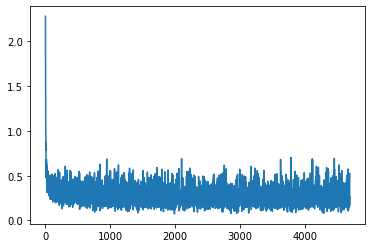

Gradients


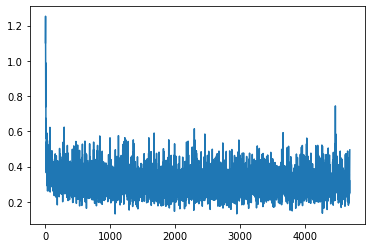

In [ ]:
model = nn.Sequential(
        nn.Linear(28 * 28, 10),
        nn.LogSoftmax(dim=1)
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, 
      optimizer, 
      criterion,
      add_view=True
      )

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9644, val: 0.9590


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9712, val: 0.9623


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9788, val: 0.9696


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9791, val: 0.9681


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9813, val: 0.9673


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9810, val: 0.9681


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9849, val: 0.9704


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9849, val: 0.9671


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9869, val: 0.9688


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9879, val: 0.9696
mean accuracy on validation dataset: 0.9670


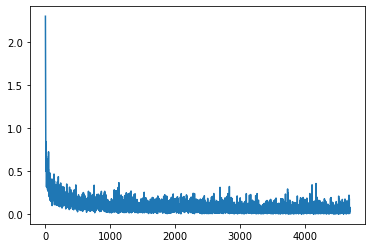

Gradients


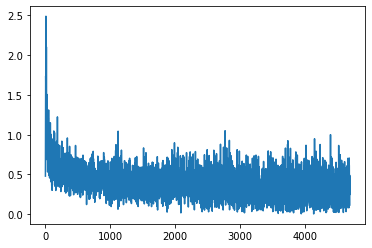

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, 
      optimizer, 
      criterion,
      add_view=True
      )

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9623, val: 0.9590


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9729, val: 0.9632


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9786, val: 0.9681


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9820, val: 0.9720


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9843, val: 0.9704


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9863, val: 0.9722


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9871, val: 0.9718


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9852, val: 0.9666


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9839, val: 0.9676


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9876, val: 0.9698
mean accuracy on validation dataset: 0.9681


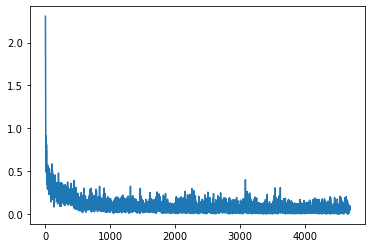

Gradients


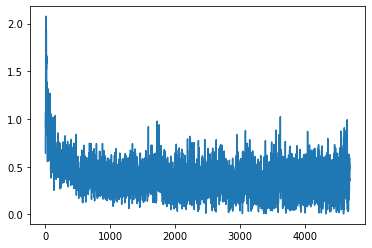

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, 
      optimizer, 
      criterion,
      add_view=True
      )

The best result achieved using linear layers is 0.967.

Addition of a convolutional layer improves accuracy

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9753, val: 0.9739


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9805, val: 0.9756


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9840, val: 0.9796


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9851, val: 0.9787


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9889, val: 0.9825


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9896, val: 0.9804


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9920, val: 0.9819


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9885, val: 0.9791


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9922, val: 0.9810


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9914, val: 0.9793
mean accuracy on validation dataset: 0.9792


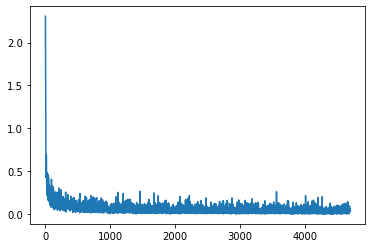

Gradients


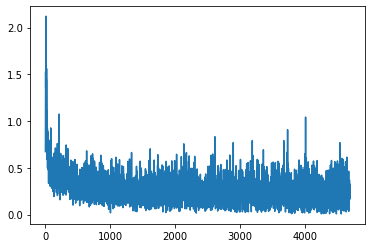

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(6 * 12 * 12, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

Try adding two linear layers

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9806, val: 0.9809


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9838, val: 0.9800


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9874, val: 0.9789


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9898, val: 0.9844


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9897, val: 0.9807


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9866, val: 0.9783


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9921, val: 0.9835


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9931, val: 0.9819


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9902, val: 0.9791


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9944, val: 0.9827
mean accuracy on validation dataset: 0.9810


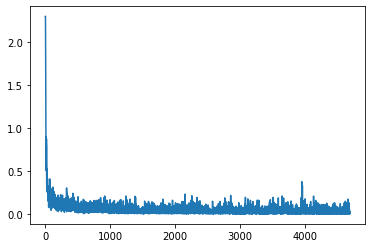

Gradients


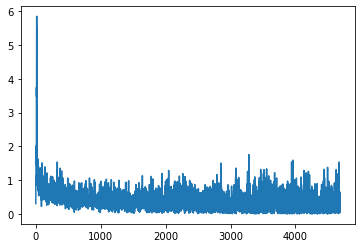

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    
    nn.Linear(6 * 12 * 12, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

Try adding Dropout

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9804, val: 0.9775


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9892, val: 0.9816


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9911, val: 0.9831


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9910, val: 0.9823


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9906, val: 0.9829


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9898, val: 0.9814


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9902, val: 0.9803


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9930, val: 0.9803


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9961, val: 0.9840


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9936, val: 0.9812
mean accuracy on validation dataset: 0.9815


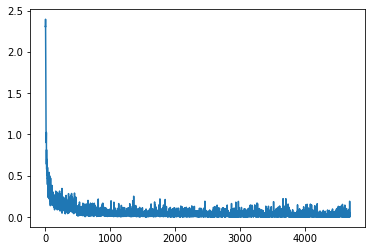

Gradients


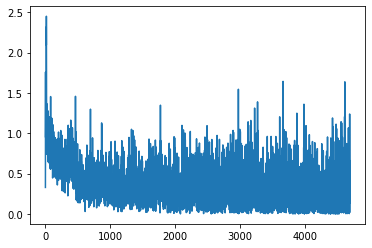

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    nn.Linear(6 * 12 * 12, 100),
    nn.Dropout(0.4),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9816, val: 0.9813


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9867, val: 0.9856


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9906, val: 0.9862


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9882, val: 0.9846


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9838, val: 0.9807


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9881, val: 0.9823


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9827, val: 0.9792


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9797, val: 0.9740


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9876, val: 0.9840


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9934, val: 0.9848
mean accuracy on validation dataset: 0.9823


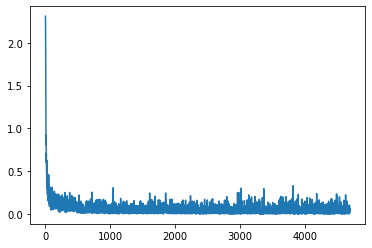

Gradients


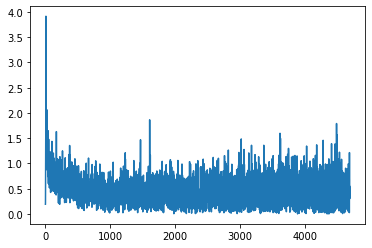

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    
    nn.Linear(16 * 4 * 4, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

Batch normalization further improves accuracy.

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9854, val: 0.9839


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9900, val: 0.9875


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9907, val: 0.9877


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9901, val: 0.9850


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9918, val: 0.9869


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9926, val: 0.9871


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9914, val: 0.9864


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9917, val: 0.9855


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9925, val: 0.9869


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9962, val: 0.9909
mean accuracy on validation dataset: 0.9868


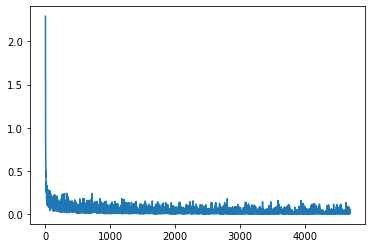

Gradients


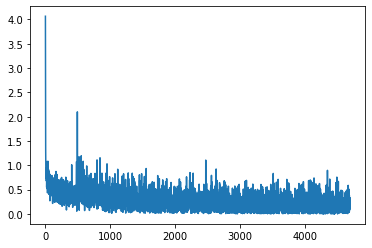

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.BatchNorm2d(6),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    
    nn.Linear(16 * 4 * 4, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

Try VGG architecture - stack several convolutional layers right after each other.

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9812, val: 0.9823


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9917, val: 0.9895


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9946, val: 0.9917


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9952, val: 0.9917


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9933, val: 0.9884


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9952, val: 0.9906


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9958, val: 0.9901


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9966, val: 0.9908


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9957, val: 0.9902


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9970, val: 0.9916
mean accuracy on validation dataset: 0.9897


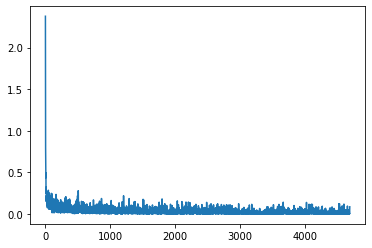

Gradients


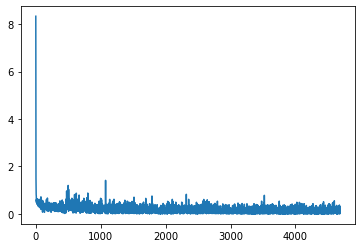

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    
    nn.Linear(64 * 4 * 4, 100),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9786, val: 0.9804


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9889, val: 0.9865


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9896, val: 0.9886


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9910, val: 0.9894


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9916, val: 0.9891


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9861, val: 0.9810


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9958, val: 0.9920


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9912, val: 0.9904


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9935, val: 0.9909


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9943, val: 0.9917
mean accuracy on validation dataset: 0.9880


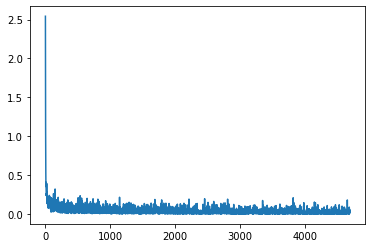

Gradients


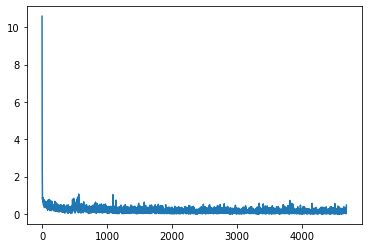

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    
    nn.Linear(64 * 2 * 2, 100),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

Without Batch Normalization model performs worse.

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9804, val: 0.9810


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.8970, val: 0.9010


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9545, val: 0.9550


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.3545, val: 0.3528


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.8970, val: 0.8980


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9420, val: 0.9448


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9458, val: 0.9459


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9598, val: 0.9601


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9696, val: 0.9680


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9713, val: 0.9699
mean accuracy on validation dataset: 0.8877


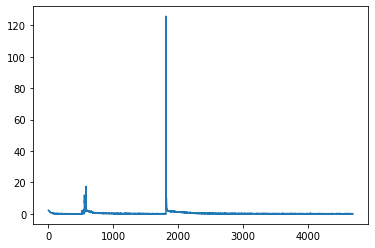

Gradients


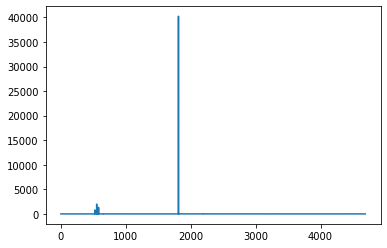

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
#    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
#    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
#    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
#    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
#    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    
    nn.Linear(64 * 2 * 2, 100),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

At first, accuracy decreased to 0.0... values. Maybe it's because the net became too deep. I changed the learning rate to 1e-3, and it solved the problem.

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9847, val: 0.9847


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9866, val: 0.9825


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9931, val: 0.9925


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9949, val: 0.9915


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9923, val: 0.9894


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9936, val: 0.9895


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9955, val: 0.9911


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9965, val: 0.9918


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9970, val: 0.9923


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9949, val: 0.9899
mean accuracy on validation dataset: 0.9895


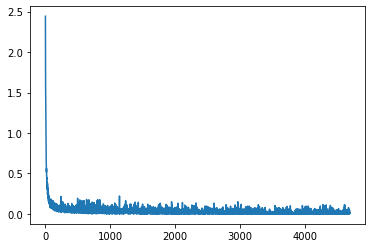

Gradients


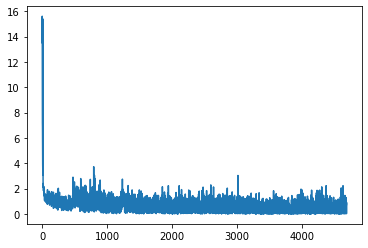

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    
    nn.Linear(64 * 2 * 2, 100),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

I'll try to manually initialize weights of the model. But it doesn't result in any improvement. 

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9898, val: 0.9855


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9927, val: 0.9892


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9901, val: 0.9856


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9958, val: 0.9914


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9970, val: 0.9909


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9946, val: 0.9887


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9959, val: 0.9901


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9969, val: 0.9914


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9967, val: 0.9913


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9964, val: 0.9910
mean accuracy on validation dataset: 0.9895


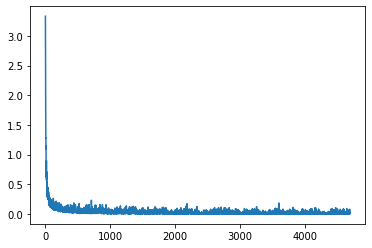

Gradients


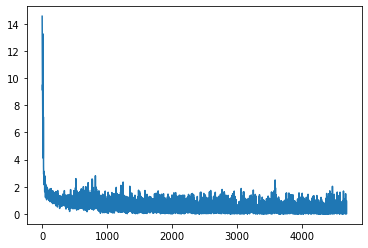

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    nn.Linear(64 * 2 * 2, 100),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)

model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

Try adding padding to convolutional layers.

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9845, val: 0.9847


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9855, val: 0.9849


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9928, val: 0.9911


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9870, val: 0.9852


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9910, val: 0.9907


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9942, val: 0.9919


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9953, val: 0.9922


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9967, val: 0.9911


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9969, val: 0.9931


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9937, val: 0.9907
mean accuracy on validation dataset: 0.9896


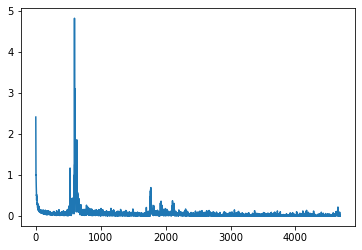

Gradients


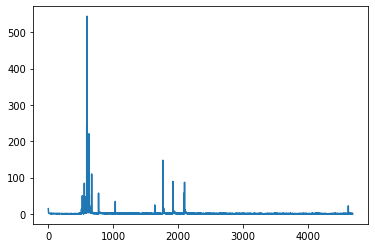

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),

    nn.Linear(64 * 7 * 7, 100),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
train(model, optimizer, criterion)

from the graph above we can see that loss grows enormously on some iterations. My hypothesis - gradient explotion. I'll try gradient clipping.

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9920, val: 0.9905


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9939, val: 0.9925


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9954, val: 0.9937


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9963, val: 0.9929


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9971, val: 0.9928


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9930, val: 0.9905


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9982, val: 0.9936


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9983, val: 0.9944


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9984, val: 0.9941


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9989, val: 0.9932
mean accuracy on validation dataset: 0.9928


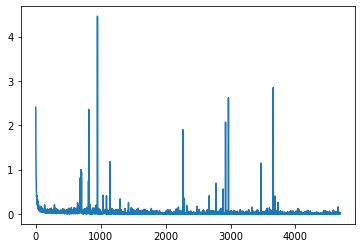

Gradients


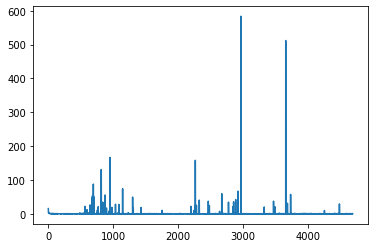

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),

    nn.Linear(64 * 7 * 7, 100),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
).to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
        
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
train(model, optimizer, criterion, add_grad_clip=True)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, train: 0.9926, val: 0.9910


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, train: 0.9909, val: 0.9897


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, train: 0.9926, val: 0.9891


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, train: 0.9921, val: 0.9872


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, train: 0.9967, val: 0.9928


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, train: 0.9970, val: 0.9935


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, train: 0.9975, val: 0.9935


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, train: 0.9976, val: 0.9934


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, train: 0.9977, val: 0.9926


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, train: 0.9976, val: 0.9922
mean accuracy on validation dataset: 0.9915


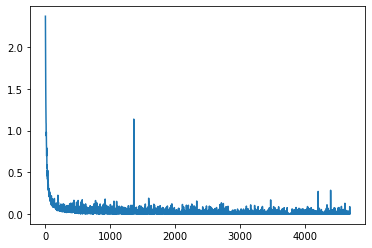

Gradients


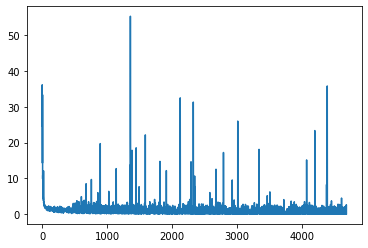

In [9]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),

    nn.Linear(128 * 3 * 3, 300),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 70),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.BatchNorm1d(70),
    nn.Linear(70, 10),
    nn.LogSoftmax(dim=1)
).to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
        
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.NLLLoss()
train(model, optimizer, criterion, add_grad_clip=True)

## Autoencoders / Morphing

In [4]:
class AutoEncoder(nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device


    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def encode(self, input):
        return self.encoder(input)

    def decode(self, input):
        return self.decoder(input)

    def forward(self, input):
        return self.decoder(self.encoder(input))

In [84]:
def train(model, optimizer, criterion, add_view=False, add_grad_clip=False, epochs=10):
    model.train()

    train_losses = []
    #gradients = []
    for epoch in tqdm(range(epochs)):
        av_loss = []
        for X, _ in tqdm(train_loader, total=int(60000 / 128) + 1):
            if add_view:
                X = X.view(-1, 784)  # разгладим картинку в вектор
            optimizer.zero_grad()
            
            output = model(X.to(device))
            loss = criterion(output, X.view(-1, 784).to(device))
            loss.backward()
            
            #if add_grad_clip:
            #    gradients.append(nn.utils.clip_grad_norm_(model.parameters(), 1.0).cpu().item())
            #else:
            #    total_norm = 0
            #    parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
            #    for p in parameters:
            #        param_norm = p.grad.detach().data.norm(2)
            #        total_norm += param_norm.item() ** 2
            #    gradients.append(total_norm ** (1. / 2))
            
            train_losses.append(loss.cpu().item())
            av_loss.append(loss.cpu().item())

            optimizer.step()

        print("epoch: %d, loss: %.4f" % (epoch + 1, sum(av_loss) / len(av_loss)))
            
    plt.plot(train_losses)
    plt.show()
#    print("Gradients")
#    plt.plot(gradients)
#    plt.show()

In [17]:
def get_view(x):
    return train_loader.dataset[x][0].view(1, 784)

def get(x):
    return train_loader.dataset[x][0].view(1, 1, 28, 28)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(model, inputs, steps, delay, add_view=False):
    model.to('cpu')
    # перегоняем в латентное пространство все картинки на входе
    for k in inputs:
        plt.show(imshow(train_loader.dataset[k][0].view(28, 28)))
    latent = []
    if add_view:
        latent = [model.encode(get_view(k)).data for k in inputs]
    else:
        latent = [model.encode(get(k)).data for k in inputs]

    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Show(nn.Module):
    def __init__(self):
        super(Show, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0561


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0479


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0456


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0444


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0438


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0433


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0429


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0426


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0423


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0422


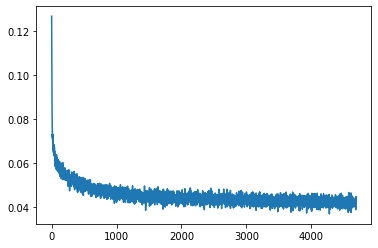

Gradients


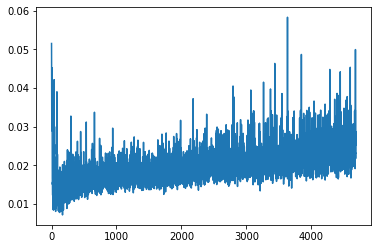

In [39]:
enc = nn.Sequential(
    nn.Linear(28 * 28, 300),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 2),
).to(device)
dec = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 300),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(300, 28 * 28),
).to(device)
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion, add_view=True)

Linear autoencoder fails to reconstruct some numbers.

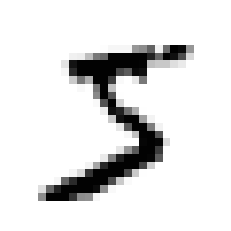

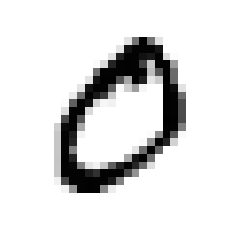

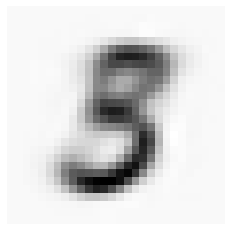

In [40]:
morph(autoenc, numpy.array([0, 1]), 20, 60)

Encoder with convolutional layers

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0578


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0508


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0484


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0469


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0460


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0453


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0448


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0445


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0442


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0441


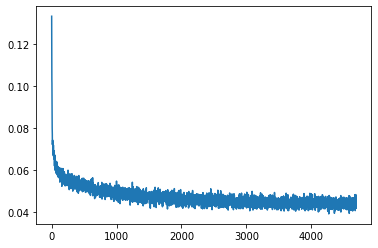

Gradients


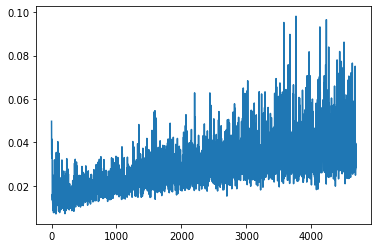

In [61]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(6 * 12 * 12, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 2),
).to(device)
dec = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 300),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(300, 28 * 28),
).to(device)
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion)

Autoencoder with convolutional layers works better but still far from ideal.

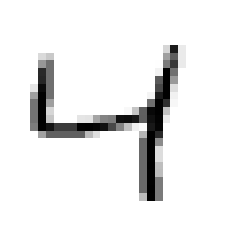

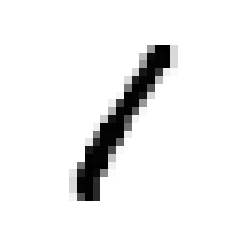

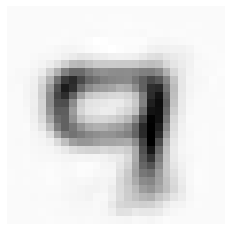

In [68]:
morph(autoenc, numpy.array([2, 3]), 20, 60)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0608


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0572


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0561


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0553


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0547


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0542


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0538


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0535


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0532


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0530


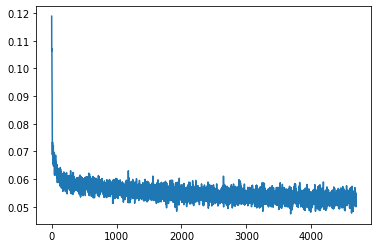

Gradients


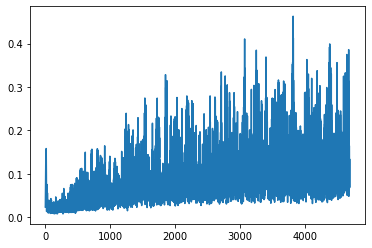

In [83]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 2, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten()
).to(device)
dec = nn.Sequential(
    Reshape(-1, 1, 1, 2),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(1, 6, 5, padding=2),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(6, 16, 5, padding=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(4 * 8 * 16, 784),
).to(device)
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion)

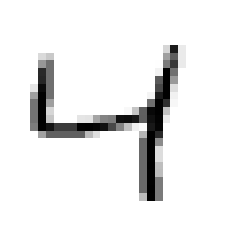

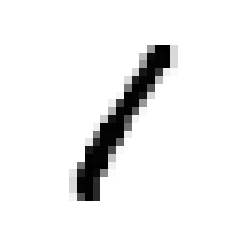

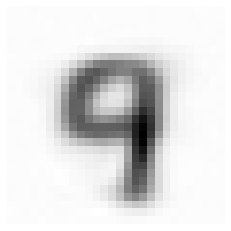

In [84]:
morph(autoenc, numpy.array([2, 3]), 20, 60)

  0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


epoch: 1, loss: 0.0620


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0570


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0557


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0550


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0543


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0537


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0532


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0528


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0523


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0520


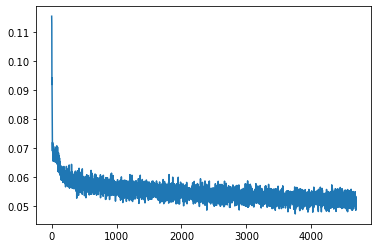

Gradients


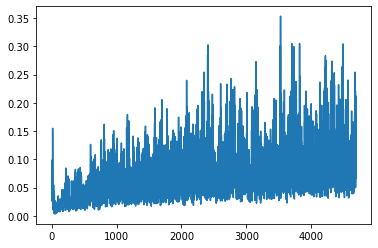

In [85]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 2, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten()
).to(device)
dec = nn.Sequential(
    Reshape(-1, 1, 1, 2),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Conv2d(1, 6, 5, padding=2),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Conv2d(6, 16, 5, padding=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(4 * 8 * 16, 784),
).to(device)
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion)

bilinear mode in upsampling gives poor results. I read somewhere that nearest neighbor mode outperforms bilinear one, and this example just approves that.

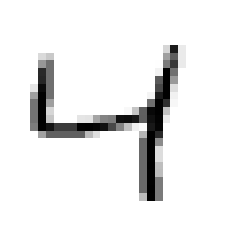

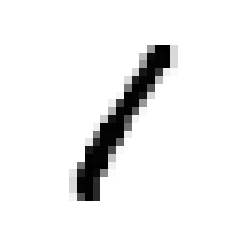

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


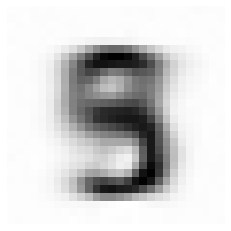

In [86]:
morph(autoenc, numpy.array([2, 3]), 20, 60)

  0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


epoch: 1, loss: 0.0465


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0344


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0324


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0312


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0304


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0299


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0295


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0291


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0288


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0285


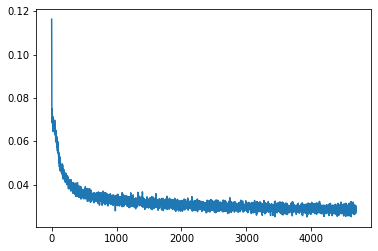

Gradients


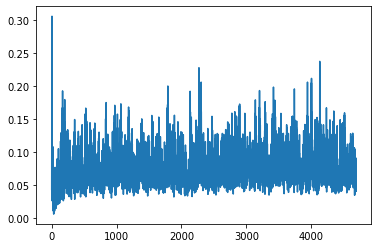

In [15]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 10, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
).to(device)
dec = nn.Sequential(
    Reshape(-1, 1, 1, 10),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Conv2d(1, 6, 5, padding=2),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Conv2d(6, 16, 5, padding=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(4 * 40 * 16, 784),
).to(device)
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion)

Here I tried to increase dimensionality of latent representation. It gave slightly better results, but the picture became noisy. My guess is that it is because of the bilinear mode of upsampling.

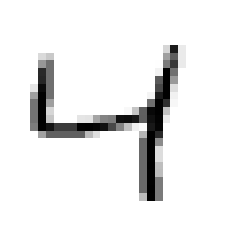

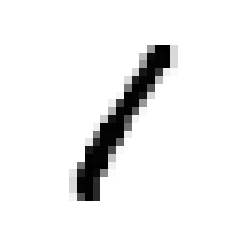

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


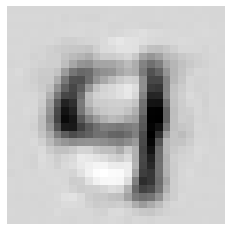

In [16]:
morph(autoenc, numpy.array([2, 3]), 20, 60)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0492


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0356


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0344


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0336


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0331


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0327


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0323


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0321


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0318


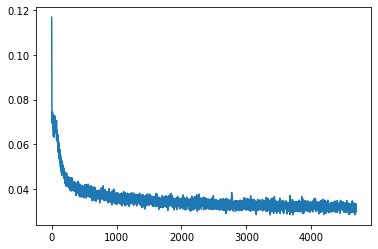

Gradients


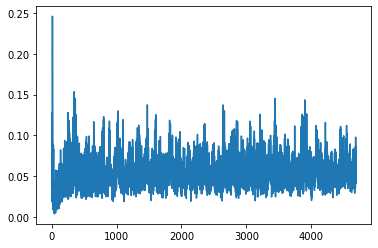

In [28]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 9, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
).to(device)
dec = nn.Sequential(
#    Show(),
    Reshape(-1, 1, 3, 3),
    nn.ConvTranspose2d(1, 6, 3, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(6, 6, 3, stride=2),
    nn.ReLU(),
#    Show(),
#    nn.Upsample(scale_factor=2, mode='bilinear'),
#    nn.Conv2d(1, 6, 5, padding=2),
#    nn.ReLU(),
#    nn.Upsample(scale_factor=2, mode='bilinear'),
#    nn.Conv2d(6, 16, 5, padding=2),
#    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(6 * 15 * 15, 784),
).to(device)
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion)

Here I tried to use transpose convolutions instead of upsampling + conv. Reconstructed picture looks bad, there are places with strong black and white colors. I read in some paper that ConvTranspose has a problem that because of mismatching kernel size and stride, some elements of input vector affect output more than other. It gets worse as number of layers increases. So in next configurations I don't use ConvTranspose.

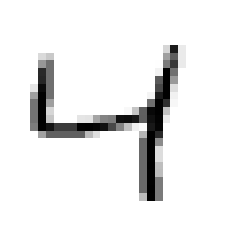

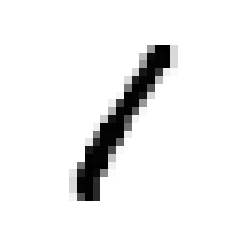

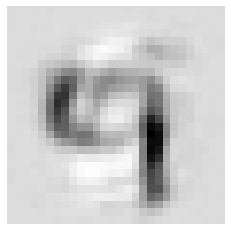

In [29]:
morph(autoenc, numpy.array([2, 3]), 20, 60)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0681


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0480


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0404


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0359


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0335


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0316


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0302


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0292


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0283


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0275


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 11, loss: 0.0267


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 12, loss: 0.0259


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 13, loss: 0.0253


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 14, loss: 0.0248


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 15, loss: 0.0243


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 16, loss: 0.0239


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 17, loss: 0.0235


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 18, loss: 0.0232


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 19, loss: 0.0228


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 20, loss: 0.0227


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 21, loss: 0.0224


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 22, loss: 0.0221


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 23, loss: 0.0220


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 24, loss: 0.0219


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 25, loss: 0.0217


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 26, loss: 0.0215


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 27, loss: 0.0212


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 28, loss: 0.0211


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 29, loss: 0.0210


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 30, loss: 0.0209


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 31, loss: 0.0207


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 32, loss: 0.0206


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 33, loss: 0.0205


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 34, loss: 0.0205


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 35, loss: 0.0203


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 36, loss: 0.0202


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 37, loss: 0.0201


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 38, loss: 0.0200


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 39, loss: 0.0199


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 40, loss: 0.0198


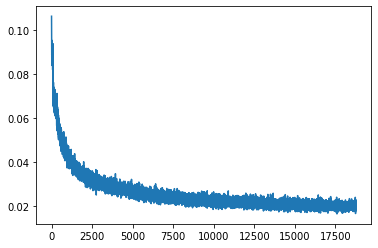

Gradients


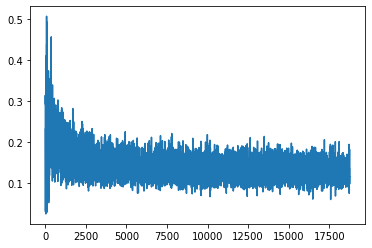

In [8]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 9, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(9, 9, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2, padding=1),
    nn.Conv2d(9, 9, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2, padding=1),
    nn.Flatten(),
).to(device)
dec = nn.Sequential(
    Reshape(-1, 1, 9, 9),
#    Show(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(1, 6, 3),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(6, 16, 5, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 1, 5, padding=1),
    nn.ReLU(),
#    Show(),
    nn.Flatten(),
).to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
                          
autoenc = AutoEncoder(enc, dec).to(device)
#optimizer = torch.optim.Adam(autoenc.parameters())
optimizer = torch.optim.Adadelta(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion, epochs=40)

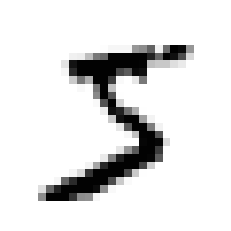

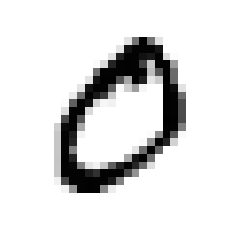

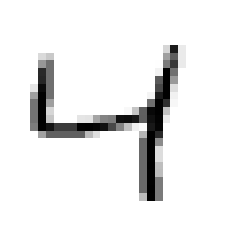

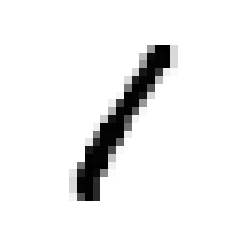

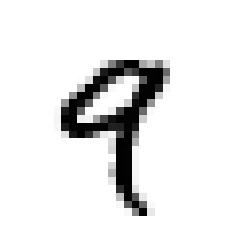

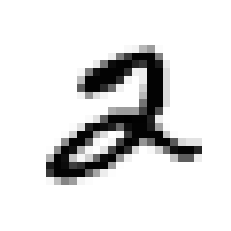

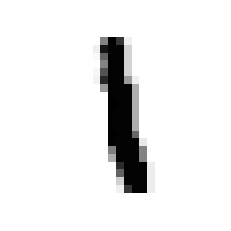

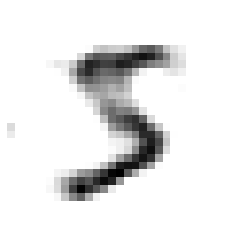

In [20]:
morph(autoenc, numpy.array([0, 1, 2, 3, 4, 5, 6]), 20, 60)

6836


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0488


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0277


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0226


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0215


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0208


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0201


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0197


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0191


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0189


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 11, loss: 0.0185


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 12, loss: 0.0182


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 13, loss: 0.0181


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 14, loss: 0.0178


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 15, loss: 0.0176


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 16, loss: 0.0174


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 17, loss: 0.0172


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 18, loss: 0.0171


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 19, loss: 0.0169


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 20, loss: 0.0167


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 21, loss: 0.0165


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 22, loss: 0.0164


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 23, loss: 0.0163


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 24, loss: 0.0161


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 25, loss: 0.0160


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 26, loss: 0.0159


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 27, loss: 0.0158


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 28, loss: 0.0157


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 29, loss: 0.0155


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 30, loss: 0.0154


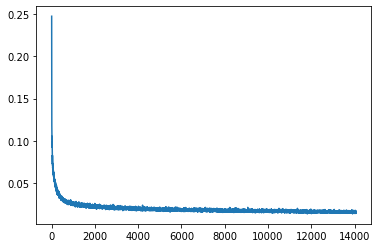

In [90]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5, padding=2),
    nn.ReLU(),
    nn.BatchNorm2d(6),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 9, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(9),
    nn.Conv2d(9, 9, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(9),
    nn.MaxPool2d(2, 2, padding=1),
    nn.Conv2d(9, 9, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(9),
    nn.MaxPool2d(2, 2, padding=1),
    nn.Flatten(),
).to(device)
dec = nn.Sequential(
    Reshape(-1, 1, 9, 9),
#    Show(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(1, 6, 3),
    nn.ReLU(),
    nn.BatchNorm2d(6),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(6, 16, 5, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 1, 5, padding=1),
    nn.ReLU(),
#    Show(),
    nn.Flatten(),
).to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
                          
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
#optimizer = torch.optim.Adadelta(autoenc.parameters())
criterion = nn.MSELoss()
print(sum(p.numel() for p in autoenc.parameters() if p.requires_grad))
train(autoenc, optimizer, criterion, epochs=30)

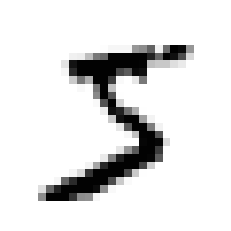

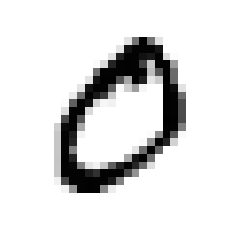

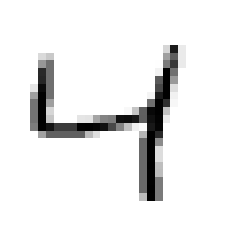

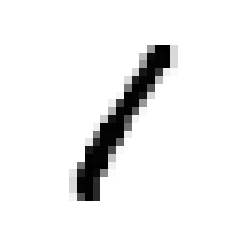

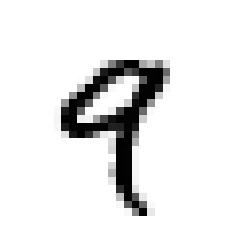

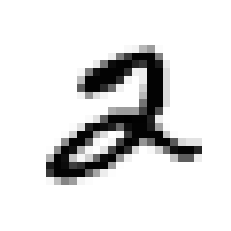

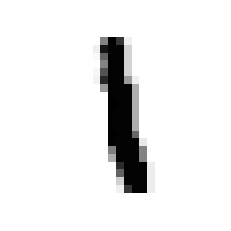

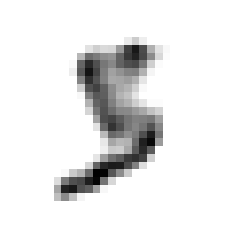

In [91]:
morph(autoenc, numpy.array([0, 1, 2, 3, 4, 5, 6]), 20, 60)

### Conclusion
Here is the best configuration that I found: 


*   There is increased dimension of latent representation
*   Some VGG is used
*   Encoder and decoder are stacks of upsampling and convolutional layers
*   There are no linear layers

Strangely enough, BatchNorm's after each convolutional layer help to decrease loss, but on animation we can see worse results.

## Autoencoders / Visualization

Here I try two configurations: network consisting solely of linear layers (+ norm, dropout), and network consisting solely of convolutional layers (+ pool, upsample, norm).

In [70]:
def to_latent(encoder, dataset, add_view=False):
    xs = []
    ys = []
    cs = []
    count = 0
    for X, y in dataset:
        if count > 20: break
        count += 1
        if add_view:
            X = X.view(-1, 784)
        else:
            X = X.view(-1, 1, 28, 28)
        
        coords = encoder(X.to(device)).cpu().detach().numpy().tolist()
        xs.extend([a for (a, b) in coords])
        ys.extend([b for (a, b) in coords])
        cs.extend(y.detach().numpy().tolist())

    return xs, ys, cs

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0862


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0508


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0491


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0481


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0472


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0466


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0460


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0454


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0451


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0446


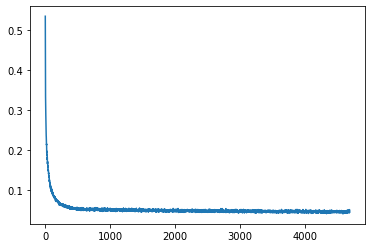

Gradients


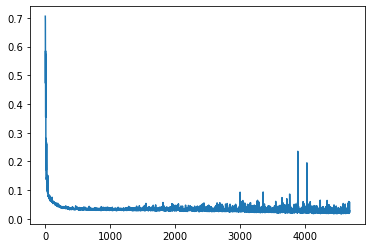

In [75]:
enc = nn.Sequential(
    nn.Linear(28 * 28, 300),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 2),
).to(device)
dec = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Dropout(0.2),
    nn.Linear(100, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Dropout(0.2),
    nn.Linear(300, 28 * 28),
).to(device)
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion, add_view=True)

In [77]:
x, y, c = to_latent(autoenc.encoder, train_loader, add_view=True)
fig = px.scatter(x=x, y=y, color=c)
fig.show()

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1, loss: 0.0635


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2, loss: 0.0546


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3, loss: 0.0516


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4, loss: 0.0497


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5, loss: 0.0486


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6, loss: 0.0478


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7, loss: 0.0472


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8, loss: 0.0466


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9, loss: 0.0462


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10, loss: 0.0457


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 11, loss: 0.0454


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 12, loss: 0.0450


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 13, loss: 0.0447


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 14, loss: 0.0447


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 15, loss: 0.0443


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 16, loss: 0.0441


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 17, loss: 0.0440


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 18, loss: 0.0437


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 19, loss: 0.0436


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 20, loss: 0.0435


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 21, loss: 0.0434


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 22, loss: 0.0433


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 23, loss: 0.0431


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 24, loss: 0.0430


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 25, loss: 0.0430


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 26, loss: 0.0429


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 27, loss: 0.0429


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 28, loss: 0.0427


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 29, loss: 0.0428


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 30, loss: 0.0426


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 31, loss: 0.0426


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 32, loss: 0.0425


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 33, loss: 0.0425


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 34, loss: 0.0424


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 35, loss: 0.0423


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 36, loss: 0.0423


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 37, loss: 0.0422


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 38, loss: 0.0422


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 39, loss: 0.0421


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 40, loss: 0.0420


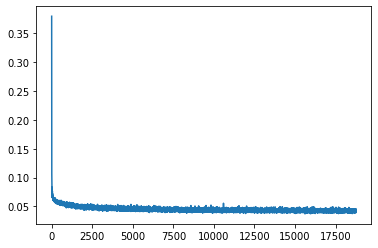

Gradients


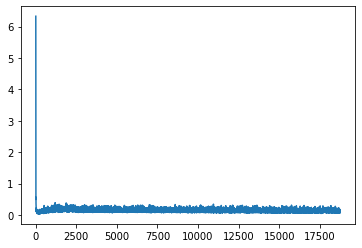

In [79]:
enc = nn.Sequential(
    nn.Conv2d(1, 6, 5, padding=2),
    nn.ReLU(),
    nn.BatchNorm2d(6),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 9, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(9, 9, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(9),
    nn.MaxPool2d(2, 2, padding=1),
    nn.Conv2d(9, 9, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(9),
    nn.MaxPool2d(2, 2, padding=1),
    nn.Conv2d(9, 1, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2, padding=(0, 1)),
#    Show(),
    nn.Flatten(),
).to(device)
dec = nn.Sequential(
    Reshape(-1, 1, 1, 2),
    nn.Upsample(scale_factor=(2, 1), mode='nearest'),
    nn.Conv2d(1, 6, 2, padding=1),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(6, 16, 5, padding=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(16, 8, 5, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(8, 1, 3, padding=1),
    nn.Flatten(),
).to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)
                          
autoenc = AutoEncoder(enc, dec).to(device)
optimizer = torch.optim.Adam(autoenc.parameters())
#optimizer = torch.optim.Adadelta(autoenc.parameters())
criterion = nn.MSELoss()
train(autoenc, optimizer, criterion, epochs=20)

In [80]:
x, y, c = to_latent(autoenc.encoder, train_loader)
fig = px.scatter(x=x, y=y, color=c)
fig.show()

### Conclusion
We can see that we can use autoencoders for dimensionality reduction and visualization. Note, that more sophisticated 'convolutional' autoencoder better separates classes from each other than simple linear one.